**Setup**

In [ ]:
import os
from collections import defaultdict
import math
import networkx as nx
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

**Import the dataset in dataframe format**

In [ ]:
df=pd.read_csv('NF-BoT-IoT.csv')

**Add an id column**

In [ ]:
df['TraficFlowID'] = range(1, len(df)+1)

**Reformulate the id column**

In [ ]:
df["TraficFlowID"] = df['TraficFlowID'].apply(lambda x: f"traffic flow {x}")

**Display the dataframe**

In [ ]:
df.head()

,IPV4_SRC_ADDR,L4_SRC_PORT,IPV4_DST_ADDR,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,Label,Attack,TraficFlowID
0,192.168.100.6,52670,192.168.100.1,53,17,5.212,71,126,1,1,0,4294966,0,Benign,traffic flow 1
1,192.168.100.6,49160,192.168.100.149,4444,6,0.000,217753000,199100,4521,4049,24,4176249,1,Theft,traffic flow 2
2,192.168.100.46,3456,192.168.100.5,80,17,0.000,8508021,8918372,9086,9086,0,4175916,0,Benign,traffic flow 3
3,192.168.100.3,80,192.168.100.55,8080,6,7.000,8442138,9013406,9086,9086,0,4175916,0,Benign,traffic flow 4
4,192.168.100.46,80,192.168.100.5,80,6,7.000,8374706,0,9086,0,0,4175916,0,Benign,traffic flow 5


**reformulate the columns IP src add, dst add, attack as numerical values**

In [ ]:
src_ipv4_idx = {name: idx for idx, name in enumerate(sorted(df["IPV4_SRC_ADDR"].unique()))}
dst_ipv4_idx = {name: idx for idx, name in enumerate(sorted(df["IPV4_DST_ADDR"].unique()))}
attack_idx = {name: idx for idx, name in enumerate(sorted(df["Attack"].unique()))}

df["IPV4_SRC_ADDR"] = df["IPV4_SRC_ADDR"].apply(lambda name: src_ipv4_idx[name])
df["IPV4_DST_ADDR"] = df["IPV4_DST_ADDR"].apply(lambda name: dst_ipv4_idx[name])
df["Attack"] = df["Attack"].apply(lambda name: attack_idx[name])



**Display the dataframe**

In [ ]:
df.head()

,IPV4_SRC_ADDR,L4_SRC_PORT,IPV4_DST_ADDR,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,Label,Attack,TraficFlowID
0,13,52670,18,53,17,5.212,71,126,1,1,0,4294966,0,0,traffic flow 1
1,13,49160,21,4444,6,0.000,217753000,199100,4521,4049,24,4176249,1,4,traffic flow 2
2,10,3456,27,80,17,0.000,8508021,8918372,9086,9086,0,4175916,0,0,traffic flow 3
3,8,80,28,8080,6,7.000,8442138,9013406,9086,9086,0,4175916,0,0,traffic flow 4
4,10,80,27,80,6,7.000,8374706,0,9086,0,0,4175916,0,0,traffic flow 5


**Construct the netflow graph for nf-bot-iot-v1**

In [ ]:
netflow_graph = nx.DiGraph()
src_nodes = set(df['IPV4_SRC_ADDR'])
dst_nodes = set(df['IPV4_DST_ADDR'])
netflow_graph.add_nodes_from(src_nodes)
netflow_graph.add_nodes_from(dst_nodes)
for _, row in df.iterrows():
    src = row['IPV4_SRC_ADDR']
    dst = row['IPV4_DST_ADDR']
    netflow_graph.add_edge(src, dst)


**Display the graph**

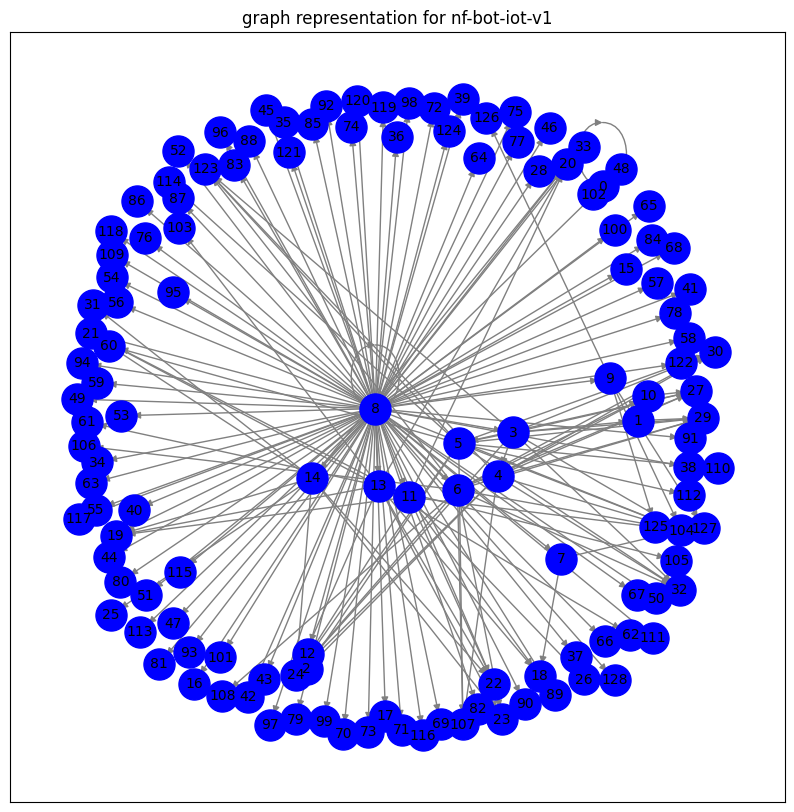

In [ ]:
plt.figure(figsize=(10, 10))
# Create a spring layout of the graph
pos = nx.spring_layout(netflow_graph)

# Draw the nodes and edges of the graph
nx.draw_networkx_nodes(netflow_graph, pos, node_color='blue', node_size=500)
nx.draw_networkx_edges(netflow_graph, pos, edge_color='gray')

# Add labels to the nodes
labels = {node: node for node in netflow_graph.nodes()}
nx.draw_networkx_labels(netflow_graph, pos, labels, font_size=10, font_family='sans-serif')
#add title
plt.title("graph representation for nf-bot-iot-v1")
# Show the graph
plt.show()

**Display the number of nodes and edges, and the average node degree**

In [ ]:
print("Total number of graph nodes:", netflow_graph.number_of_nodes())
print("Total number of graph edges:", netflow_graph.number_of_edges())
degrees = [netflow_graph.degree[node] for node in netflow_graph.nodes]
print("Average node degree:", round(sum(degrees) / len(degrees), 2))

Total number of graph nodes: 129
Total number of graph edges: 181
Average node degree: 2.81


**Train node embedding**

we will learn the embedding for the nodes using skip gram algorithm

In [ ]:
#initialise the vocabulary used for generating skip gram pairs
vocabulary = ["NA"] + list(netflow_graph.nodes)
vocabulary_lookup = {token: idx for idx, token in enumerate(vocabulary)}

start the random walk from a given node by defining two hyperparameters p,q

In [ ]:
def next_step(graph, previous, current, p, q):
    neighbors = list(graph.neighbors(current))
    if not neighbors:
        return current
    next = np.random.choice(neighbors, size=1)[0]
    return next

def random_walk(graph, num_walks, num_steps, p, q):
    walks = []
    nodes = list(graph.nodes())
    # Perform multiple iterations of the random walk.
    for walk_iteration in range(num_walks):
        random.shuffle(nodes)

        for node in nodes:
            # Start the walk with a random node from the graph.
            walk = [node]
            # Randomly walk for num_steps.
            while len(walk) < num_steps:
                current = walk[-1]
                previous = walk[-2] if len(walk) > 1 else None
                # Compute the next node to visit.
                next = next_step(graph, previous, current, p, q)
                walk.append(next)
            # Replace node ids (movie ids) in the walk with token ids.
            walk = [vocabulary_lookup[token] for token in walk]
            # Add the walk to the generated sequence.
            walks.append(walk)

    return walks

In [ ]:
# return parameter.
p = 1
# n-out parameter.
q = 1
# Number of iterations of random walks.
num_walks = 5
# Number of steps of each random walk.
num_steps = 10
walks = random_walk(netflow_graph, num_walks, num_steps, p, q)

print("{} walks generated:".format(len(walks)))

645 walks generated:


**Train the skip gram model**

In [ ]:
def generate_examples(sequences, window_size, num_negative_samples, vocabulary_size):
    example_weights = defaultdict(int)
    # Iterate over all sequences (walks).
    for sequence in sequences:
        # Generate positive and negative skip-gram pairs for a sequence (walk).
        pairs, labels = keras.preprocessing.sequence.skipgrams(
            sequence,
            vocabulary_size=vocabulary_size,
            window_size=window_size,
            negative_samples=num_negative_samples,
        )
        for idx in range(len(pairs)):
            pair = pairs[idx]
            label = labels[idx]
            target, context = min(pair[0], pair[1]), max(pair[0], pair[1])
            if target == context:
                continue
            entry = (target, context, label)
            example_weights[entry] += 1

    targets, contexts, labels, weights = [], [], [], []
    for entry in example_weights:
        weight = example_weights[entry]
        target, context, label = entry
        targets.append(target)
        contexts.append(context)
        labels.append(label)
        weights.append(weight)

    return np.array(targets), np.array(contexts), np.array(labels), np.array(weights)


num_negative_samples = 4
targets, contexts, labels, weights = generate_examples(
    sequences=walks,
    window_size=num_steps,
    num_negative_samples=num_negative_samples,
    vocabulary_size=len(vocabulary),
)

Define the hyperparameters

In [ ]:
batch_size = 1024
learning_rate = 0.001
embedding_dim = 50
num_epochs = 10

In [ ]:
def create_dataset(targets, contexts, labels, weights, batch_size):
    inputs = {
        "target": targets,
        "context": contexts,
    }
    dataset = tf.data.Dataset.from_tensor_slices((inputs, labels, weights))
    dataset = dataset.shuffle(buffer_size=batch_size * 2)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset


dataset = create_dataset(
    targets=targets,
    contexts=contexts,
    labels=labels,
    weights=weights,
    batch_size=batch_size,
)

In [ ]:
def create_model(vocabulary_size, embedding_dim):

    inputs = {
        "target": layers.Input(name="target", shape=(), dtype="int32"),
        "context": layers.Input(name="context", shape=(), dtype="int32"),
    }
    # Initialize item embeddings.
    embed_item = layers.Embedding(
        input_dim=vocabulary_size,
        output_dim=embedding_dim,
        embeddings_initializer="he_normal",
        embeddings_regularizer=keras.regularizers.l2(1e-6),
        name="item_embeddings",
    )
    # Lookup embeddings for target.
    target_embeddings = embed_item(inputs["target"])
    # Lookup embeddings for context.
    context_embeddings = embed_item(inputs["context"])
    # Compute dot similarity between target and context embeddings.
    logits = layers.Dot(axes=1, normalize=False, name="dot_similarity")(
        [target_embeddings, context_embeddings]
    )
    # Create the model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [ ]:
model = create_model(len(vocabulary), embedding_dim)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
)

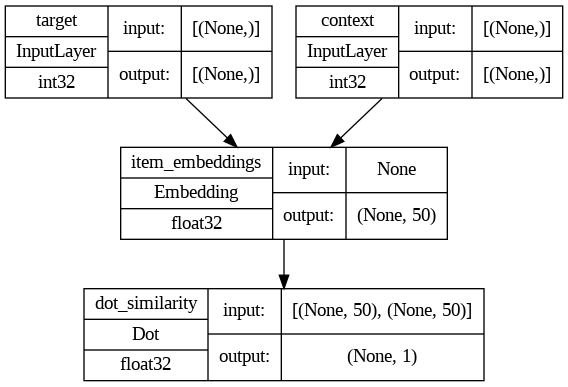

In [ ]:
keras.utils.plot_model(
    model,
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
)

**display the learning curve**

In [ ]:
history = model.fit(dataset, epochs=num_epochs)

Epoch 1/10
8/8 [==============================] - 1s 11ms/step - loss: 19.4163
Epoch 2/10
8/8 [==============================] - 0s 12ms/step - loss: 19.3737
Epoch 3/10
8/8 [==============================] - 0s 14ms/step - loss: 19.3629
Epoch 4/10
8/8 [==============================] - 0s 10ms/step - loss: 19.3565
Epoch 5/10
8/8 [==============================] - 0s 11ms/step - loss: 19.3457
Epoch 6/10
8/8 [==============================] - 0s 11ms/step - loss: 19.3392
Epoch 7/10
8/8 [==============================] - 0s 10ms/step - loss: 19.3380
Epoch 8/10
8/8 [==============================] - 0s 12ms/step - loss: 19.3222
Epoch 9/10
8/8 [==============================] - 0s 13ms/step - loss: 19.3245
Epoch 10/10
8/8 [==============================] - 0s 11ms/step - loss: 19.3315


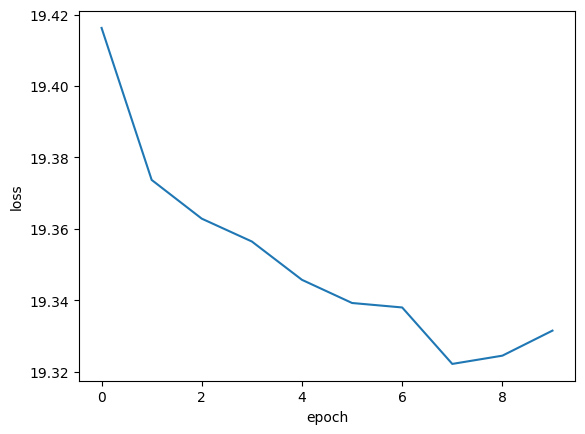

In [ ]:
plt.plot(history.history["loss"])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

Embedding matrix dimensions

In [ ]:
netflow_embeddings = model.get_layer("item_embeddings").get_weights()[0]
print("Embeddings shape:", netflow_embeddings.shape)

Embeddings shape: (130, 50)


save the embeddings in tab separated values table

In [ ]:
import io

out_v = io.open("nf-bot-iot-v1_embeddings.tsv", "w", encoding="utf-8")
out_m = io.open("nf-bot-iot-v1_metadata.tsv", "w", encoding="utf-8")

for idx, net_id in enumerate(vocabulary[1:]):
    traffic_id = list(list(df.TraficFlowID))[idx]
    vector = netflow_embeddings[idx]
    out_v.write("\t".join([str(x) for x in vector]) + "\n")
    out_m.write(traffic_id + "\n")

out_v.close()
out_m.close()